In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
# import kaggle
from datasets import load_dataset
import copy
import torch
from sklearn.cluster import KMeans
import kmedoids
from sklearn.metrics import pairwise_distances

import os
import matplotlib.pyplot as plt
import cv2
from difflib import get_close_matches

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

C:\Users\aa310\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [169]:
from utils import *

In [2]:
higging_face_df = load_dataset("Grandediw/clash-royale-battle")

In [3]:
df = higging_face_df['train'].to_pandas()
all_card_ids = set()
for i in range(8):
  all_card_ids = all_card_ids.union(list(df[f"winner.card{i+1}.id"].unique()))
  all_card_ids = all_card_ids.union(list(df[f"loser.card{i+1}.id"].unique()))
all_card_ids = sorted(list(all_card_ids))

In [4]:
remove_cols = [
 'Unnamed: 0',
 'battleTime',
#  'arena.id',      # Filter
#  'gameMode.id',   # Filter
 # 'average.startingTrophies',  # Filter
 'winner.tag',
#  'winner.startingTrophies',
 'winner.trophyChange',
 'winner.crowns',
 'winner.kingTowerHitPoints',#
 'winner.princessTowersHitPoints',
 'winner.clan.tag',
 'winner.clan.badgeId',
 'loser.tag',
#  'loser.startingTrophies',
 'loser.trophyChange',
 'loser.crowns',
 'loser.kingTowerHitPoints',
 'loser.clan.tag',
 'loser.clan.badgeId', #
 'loser.princessTowersHitPoints',
 'tournamentTag',
 'winner.card1.id',
#  'winner.card1.level',
 'winner.card2.id',
#  'winner.card2.level',
 'winner.card3.id',
#  'winner.card3.level',
 'winner.card4.id',
#  'winner.card4.level',
 'winner.card5.id',
#  'winner.card5.level',
 'winner.card6.id',
#  'winner.card6.level',
 'winner.card7.id',
#  'winner.card7.level',
 'winner.card8.id',
#  'winner.card8.level',
#  'winner.cards.list',
 'winner.totalcard.level',  # TODO
#  'winner.troop.count',
#  'winner.structure.count',
#  'winner.spell.count',
 'winner.common.count',
 'winner.rare.count',
 'winner.epic.count',
 'winner.legendary.count',
#  'winner.elixir.average',
 'loser.card1.id',
#  'loser.card1.level',
 'loser.card2.id',
#  'loser.card2.level',
 'loser.card3.id',
#  'loser.card3.level',
 'loser.card4.id',
#  'loser.card4.level',
 'loser.card5.id',
#  'loser.card5.level',
 'loser.card6.id',
#  'loser.card6.level',
 'loser.card7.id',
#  'loser.card7.level',
 'loser.card8.id',
#  'loser.card8.level',
#  'loser.cards.list',
 'loser.totalcard.level',   # TODO
#  'loser.troop.count',
#  'loser.structure.count',
#  'loser.spell.count',
 'loser.common.count',
 'loser.rare.count',
 'loser.epic.count',
 'loser.legendary.count',
#  'loser.elixir.average'
 ]

df.drop(remove_cols, axis=1, inplace=True)
df.drop(df[df['arena.id'] != 54000050.0].index, inplace=True)
df_mode1 = df.drop(df[df['gameMode.id'] != 72000006.0].index, inplace=False)
df_mode2 = df.drop(df[df['gameMode.id'] != 72000201.0].index, inplace=False)
df_mode1.drop(["arena.id", "gameMode.id"], axis=1, inplace=True)
df_mode2.drop(["arena.id", "gameMode.id"], axis=1, inplace=True)

for i in range(8):
  df_mode1.drop(df_mode1[df_mode1[f"loser.card{i+1}.level"] != 13].index, inplace=True)
  df_mode1.drop(df_mode1[df_mode1[f"winner.card{i+1}.level"] != 13].index, inplace=True)
  df_mode2.drop(df_mode2[df_mode2[f"loser.card{i+1}.level"] != 13].index, inplace=True)
  df_mode2.drop(df_mode2[df_mode2[f"winner.card{i+1}.level"] != 13].index, inplace=True)
  df_mode1.drop([f"loser.card{i+1}.level"], axis=1, inplace=True)
  df_mode1.drop([f"winner.card{i+1}.level"], axis=1, inplace=True)
  df_mode2.drop([f"loser.card{i+1}.level"], axis=1, inplace=True)
  df_mode2.drop([f"winner.card{i+1}.level"], axis=1, inplace=True)

In [5]:
df_mode1 = df_mode1.sort_values(by='average.startingTrophies', ascending=False).head(10000)
df_mode1

,average.startingTrophies,winner.startingTrophies,loser.startingTrophies,winner.cards.list,winner.troop.count,winner.structure.count,winner.spell.count,winner.elixir.average,loser.cards.list,loser.troop.count,loser.structure.count,loser.spell.count,loser.elixir.average
305194,7066.5,7005.0,7128.0,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250,"[26000000, 26000010, 26000023, 27000006, 27000...",3,2,3,3.500
1624463,7030.0,7035.0,7025.0,"[26000000, 26000010, 26000023, 27000006, 27000...",3,2,3,3.500,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250
187746,7023.0,7018.0,7028.0,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250,"[26000009, 26000013, 26000015, 26000035, 26000...",6,0,2,4.375
366652,7021.5,6983.0,7060.0,"[26000009, 26000012, 26000015, 26000043, 26000...",6,0,2,4.250,"[26000003, 26000016, 26000027, 26000032, 26000...",6,0,2,3.750
1505223,7018.5,7031.0,7006.0,"[26000006, 26000011, 26000032, 26000039, 26000...",5,1,2,3.625,"[26000005, 26000006, 26000008, 26000022, 26000...",6,0,2,4.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179895,6340.0,6319.0,6361.0,"[26000006, 26000032, 26000038, 26000044, 26000...",5,0,3,2.875,"[26000000, 26000001, 26000030, 27000002, 27000...",3,2,3,3.250
1844870,6340.0,6344.0,6336.0,"[26000028, 26000044, 26000046, 26000047, 26000...",5,1,2,4.750,"[26000000, 26000014, 26000019, 26000054, 26000...",5,1,2,3.375
1711520,6340.0,6329.0,6351.0,"[26000003, 26000005, 26000008, 26000013, 26000...",6,0,2,3.875,"[26000006, 26000008, 26000029, 26000039, 26000...",5,1,2,4.125
1619294,6340.0,6344.0,6336.0,"[26000000, 26000001, 26000004, 26000006, 26000...",6,0,2,4.000,"[26000000, 26000019, 26000032, 26000049, 26000...",5,1,2,2.500


In [6]:
cards1 = pd.read_csv("data//Wincons.csv")
cards2 = pd.read_csv("data//CardMasterListSeason18_12082020.csv")
id1 = cards1["card_id"]
names1 = cards1["card_name"]
id2 = cards2["team.card1.id"]
names2 = cards2["team.card1.name"]
id_to_name = {}
for i in range(len(id1)):
    id_to_name[id1[i].item()] = names1[i]
for i in range(len(id2)):
    id_to_name[id2[i].item()] = names2[i]
total_num_cards = len(id_to_name)
id_to_id = {}
id_to_id_reversed = {}
for i, idd in enumerate(id_to_name.keys()):
    id_to_id[idd] = i
    id_to_id_reversed[i] = idd

matches = getMatches(df_mode1, total_num_cards, id_to_id)

In [87]:
decks = []
wins = []
for match_id in range(0, len(matches), 2):
    match = matches[match_id]
    decks.append(match[0].winner_info["cards"])
    decks.append(match[0].loser_info["cards"])
    wins.append(1)
    wins.append(0)
decks = np.array(decks)
wins = np.array(wins)

In [91]:
metric = "l1"
num_clusters = 40
clustering_result_folder = f"kmedoids_{metric}_{num_clusters}"
if os.path.exists(clustering_result_folder):
    distance_matrix = np.load(clustering_result_folder+"//distance_matrix.npy")
    print("Loaded distance matrix from file.")
    labels_ = np.load(clustering_result_folder+"//labels_.npy")
    medoid_indices_ = np.load(clustering_result_folder+"//medoid_indices_.npy")
    print("Loaded kmedoids result from file.")

else:
    distance_matrix = pairwise_distances(decks, metric=metric)
    km = kmedoids.KMedoids(num_clusters, method='fasterpam')
    km.fit(distance_matrix)
    labels_ = km.labels_
    medoid_indices_ = km.medoid_indices_
    os.makedirs(clustering_result_folder, exist_ok=True)
    np.save(clustering_result_folder+"//distance_matrix.npy", distance_matrix)
    print("Computed and saved distance matrix.")
    np.save(clustering_result_folder+"//labels_.npy", labels_)
    np.save(clustering_result_folder+"//medoid_indices_.npy", medoid_indices_)
    print("Computed and saved kmedoids result.")

Computed and saved distance matrix.
Computed and saved kmedoids result.


In [236]:
folder_path = "data//CR_Pic"
    
all_popular_decks = []
for idx in range(num_clusters):
    ids = np.nonzero(decks[medoid_indices_[idx]])[0]
    card_names = [id_to_name[id_to_id_reversed[idd]] for idd in ids]
    all_popular_decks.append(card_names)

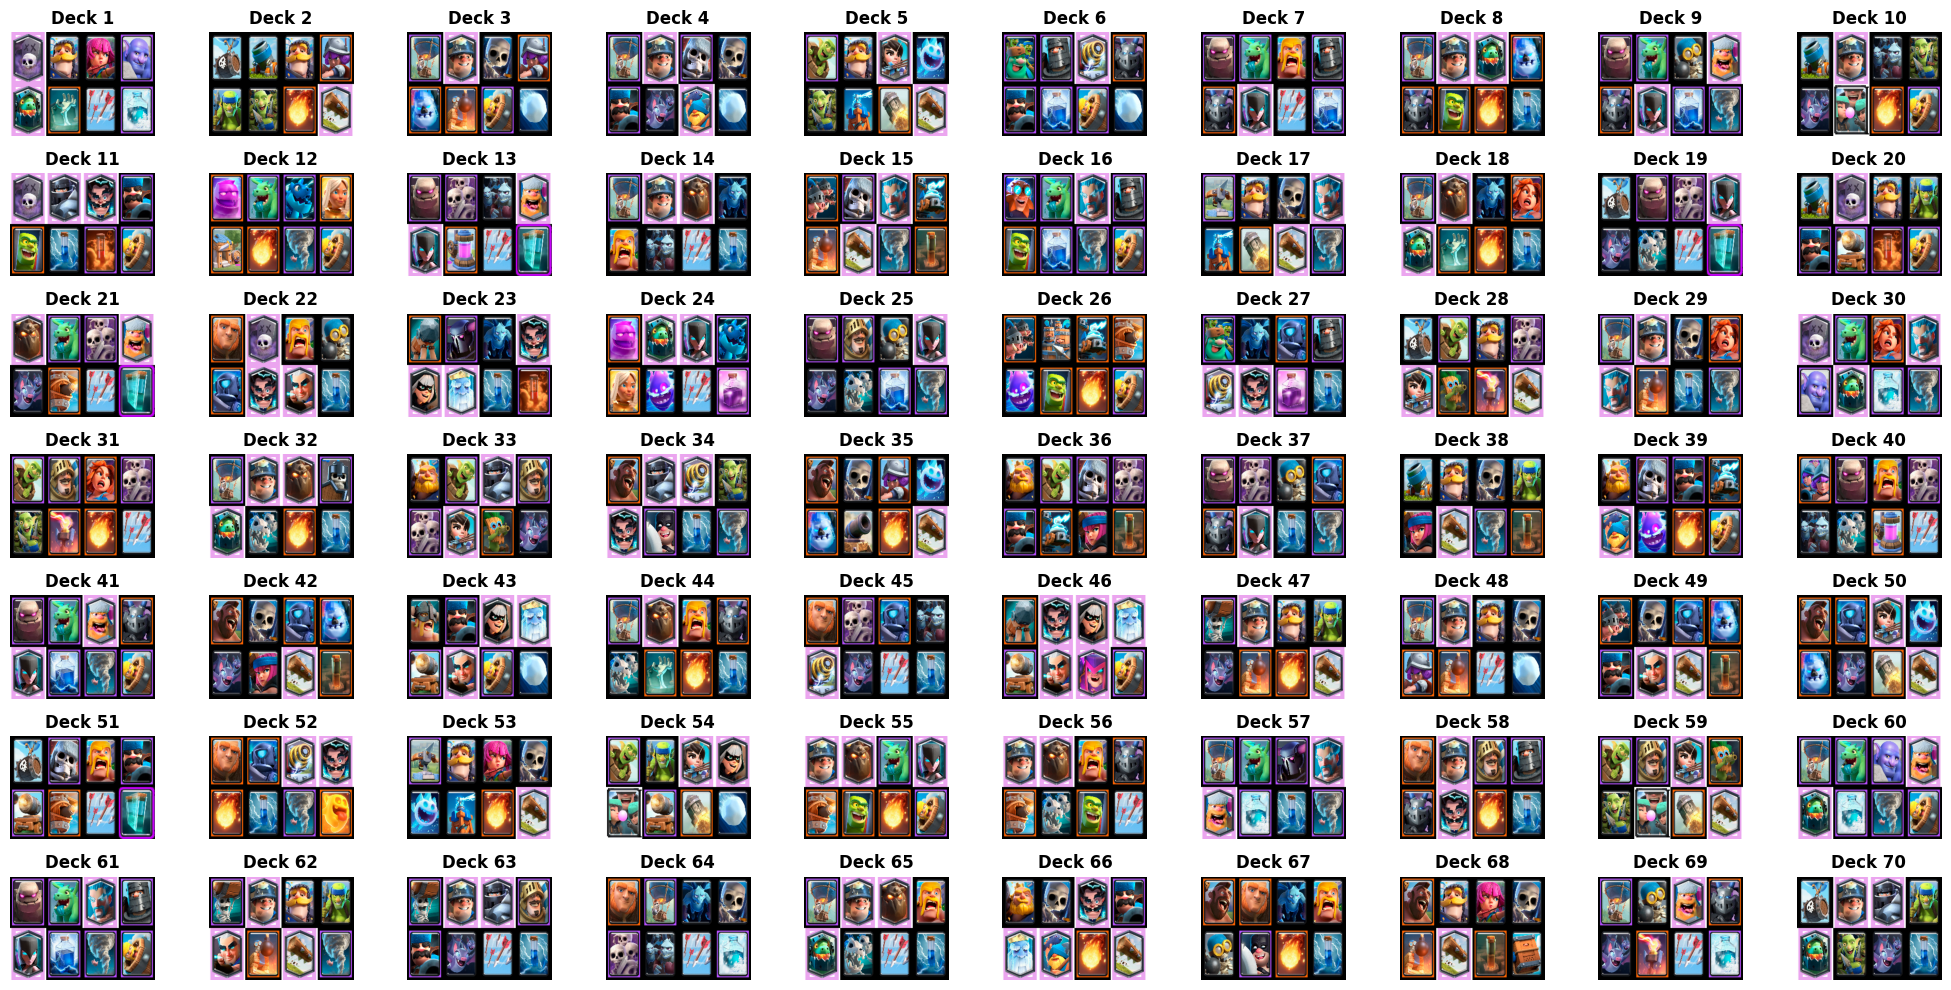

In [238]:
draw_decks(all_popular_decks, folder_path, 9, 10)

Computed and saved tSNE result.


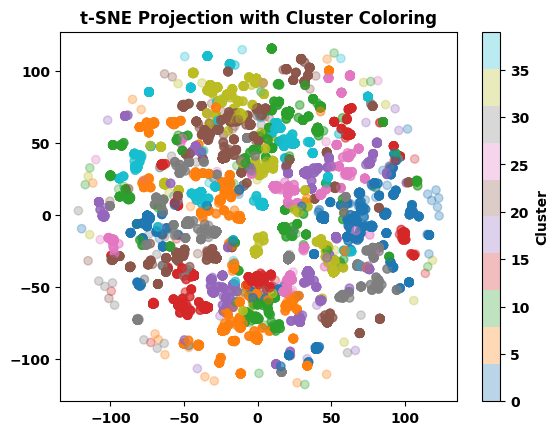

In [97]:
from sklearn.manifold import TSNE

if os.path.exists(clustering_result_folder+"//X_embedded.npy"):
    X_embedded = np.load(clustering_result_folder+"//X_embedded.npy")
    print("Loaded tSNE result from file.")
else:
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_embedded = tsne.fit_transform(decks)
    os.makedirs(clustering_result_folder, exist_ok=True)
    np.save(clustering_result_folder+"//X_embedded.npy", X_embedded)
    print("Computed and saved tSNE result.")

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=km.labels_, cmap='tab10', alpha=0.3)
plt.title("t-SNE Projection with Cluster Coloring")
plt.colorbar(label='Cluster')
plt.show()

In [99]:
num_wins_per_cluster = np.zeros(num_clusters)
for cluster_id in range(num_clusters):
    num_wins_per_cluster[cluster_id] = ((km.labels_ == cluster_id) * wins).sum() / (km.labels_ == cluster_id).sum()
print(num_wins_per_cluster)

[0.49847561 0.49597238 0.47583643 0.50728155 0.5        0.5097493
 0.49678013 0.5326087  0.49       0.50569476 0.49708738 0.50342131
 0.50617284 0.53072626 0.48471616 0.53063344 0.50497866 0.49450549
 0.50246305 0.52023121 0.50285714 0.50390625 0.50769231 0.48291233
 0.5042735  0.53416149 0.48514851 0.47280335 0.47702407 0.48055556
 0.49575758 0.51246537 0.48496241 0.48543689 0.50111359 0.49610592
 0.48351648 0.49876543 0.53571429 0.46003263]


In [155]:
(pairwise_distances(decks[km.medoid_indices_], metric=metric) + np.eye(num_clusters)*1000 < 4).sum()

np.int64(10)

In [157]:
metric = "l1"
num_clusters = 90
clustering_result_folder = f"kmedoids_{metric}_{num_clusters}"
if os.path.exists(clustering_result_folder):
    distance_matrix = np.load(clustering_result_folder+"//distance_matrix.npy")
    print("Loaded distance matrix from file.")
    labels_ = np.load(clustering_result_folder+"//labels_.npy")
    medoid_indices_ = np.load(clustering_result_folder+"//medoid_indices_.npy")
    print("Loaded kmedoids result from file.")

else:
    distance_matrix = pairwise_distances(decks, metric=metric)
    km = kmedoids.KMedoids(num_clusters, method='fasterpam')
    km.fit(distance_matrix)
    labels_ = km.labels_
    medoid_indices_ = km.medoid_indices_
    os.makedirs(clustering_result_folder, exist_ok=True)
    np.save(clustering_result_folder+"//distance_matrix.npy", distance_matrix)
    print("Computed and saved distance matrix.")
    np.save(clustering_result_folder+"//labels_.npy", labels_)
    np.save(clustering_result_folder+"//medoid_indices_.npy", medoid_indices_)
    print("Computed and saved kmedoids result.")

num_wins_per_cluster = np.zeros(num_clusters)
for cluster_id in range(num_clusters):
    num_wins_per_cluster[cluster_id] = ((km.labels_ == cluster_id) * wins).sum() / (km.labels_ == cluster_id).sum()
print(num_wins_per_cluster)

Computed and saved distance matrix.
Computed and saved kmedoids result.
[0.49180328 0.53363229 0.51904762 0.51333333 0.48802395 0.55102041
 0.54716981 0.47457627 0.4384058  0.46575342 0.4953271  0.45901639
 0.56129032 0.62184874 0.53216374 0.59487179 0.51497006 0.47679325
 0.41666667 0.51916376 0.47247706 0.5        0.48717949 0.47126437
 0.47115385 0.48051948 0.49760766 0.51612903 0.51851852 0.56372549
 0.38787879 0.53068592 0.49342105 0.47126437 0.46896552 0.51639344
 0.52681388 0.50322581 0.52980132 0.51485149 0.49908925 0.55725191
 0.54098361 0.47160069 0.49069374 0.52727273 0.4922426  0.45945946
 0.48427673 0.47126437 0.51948052 0.55434783 0.5        0.58536585
 0.50769231 0.53061224 0.52244898 0.51948052 0.47486034 0.47435897
 0.52341598 0.50485437 0.5060241  0.5        0.46769231 0.47704591
 0.3943662  0.46991404 0.51685393 0.49420849 0.52873563 0.54237288
 0.59433962 0.50107991 0.56451613 0.46376812 0.51898734 0.52197802
 0.47933884 0.48076923 0.5        0.48880597 0.51320755 0

In [204]:
class MatchSampler(torch.utils.data.Dataset):
    def __init__(self, matches):
        self.matches = matches

    def __len__(self):
        return len(self.matches)

    def __getitem__(self, idx):
        match = self.matches[idx][0]
        return_dic = {
            "my_cards" : match.winner_info["cards"],
            "my_features" : np.array([match.winner_info["troop_count"], match.winner_info["structure_count"], match.winner_info["spell_count"], match.winner_info["elixir_average"]]),
            "my_Trophies" : match.winner_info["Trophies"],
            "my_troop_count" : match.winner_info["troop_count"],
            "my_structure_count" : match.winner_info["structure_count"],
            "my_spell_count" : match.winner_info["spell_count"],
            "my_elixir_average" : match.winner_info["elixir_average"],

            "opponent_cards" : match.loser_info["cards"],
            "opponent_features" : np.array([match.loser_info["troop_count"], match.loser_info["structure_count"], match.loser_info["spell_count"], match.loser_info["elixir_average"]]),
            "opponent_Trophies" : match.loser_info["Trophies"],
            "opponent_troop_count" : match.loser_info["troop_count"],
            "opponent_structure_count" : match.loser_info["structure_count"],
            "opponent_spell_count" : match.loser_info["spell_count"],
            "opponent_elixir_average" : match.loser_info["elixir_average"],

            "labels" : self.matches[idx][1]
        }

        return return_dic

In [18]:
dataset_sampler[0]

NameError: name 'dataset_sampler' is not defined

In [206]:
batch_size = 100

dataset_sampler = MatchSampler(matches)

train_size = int(0.8 * len(dataset_sampler))
test_size = len(dataset_sampler) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_sampler, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [254]:
class PredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_hidden_layers):
        super(PredModel, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)  # Input layer
        self.attn_layer_1 = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.attn_layer_2 = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, deck1, deck2, feature1, feature2):
        x = torch.cat([deck1, deck2], axis=-1)
        y = F.relu(self.input_layer(x)) 
        y = y.unsqueeze(1)
        attn_output_1, _ = self.attn_layer_1(y, y, y) 
        attn_output_2, _ = self.attn_layer_2(attn_output_1, attn_output_1, attn_output_1)
        attn_output_2 = attn_output_2.squeeze(1)
        
        residual = attn_output_2
        for layer in self.hidden_layers:
            y = F.relu(layer(attn_output_2))
            y += residual
            residual = y
        win_probability = torch.sigmoid(self.output_layer(y))  # Win probability (0-1)
        return win_probability


In [266]:
def train(model, num_epochs, lr, train_dataloader, test_dataloader, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loss = []
    train_acc = []
    eval_acc = []

    model = model.to(device)

    for epoch in range(num_epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        model.train()

        for i, data in enumerate(train_dataloader):
            my_cards = torch.tensor(data["my_cards"]).float().to(device)
            opponent_cards = torch.tensor(data["opponent_cards"]).float().to(device)
            my_features = torch.tensor(data["my_features"]).float().to(device)
            opponent_features = torch.tensor(data["opponent_features"]).float().to(device)
            labels = torch.tensor(data["labels"]).to(device)

            optimizer.zero_grad()
            ypred = model(my_cards, opponent_cards, my_features, opponent_features)

            loss = criterion(ypred, labels)
            epoch_loss += loss.detach().cpu().item()
            loss.backward()
            optimizer.step()

            predictions = torch.argmax(ypred, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / len(train_dataloader)
        accuracy = 100 * correct / total

        train_loss.append(avg_loss)
        train_acc.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        if (epoch + 1) % 2 == 0:
            model.eval()
            eval_correct = 0
            eval_total = 0

            with torch.no_grad():
                for data in test_dataloader:
                    my_cards = torch.tensor(data["my_cards"]).float().to(device)
                    opponent_cards = torch.tensor(data["opponent_cards"]).float().to(device)
                    my_features = torch.tensor(data["my_features"]).float().to(device)
                    opponent_features = torch.tensor(data["opponent_features"]).float().to(device)
                    labels = torch.tensor(data["labels"]).to(device)

                    ypred = model(my_cards, opponent_cards, my_features, opponent_features)
                    predictions = torch.argmax(ypred, dim=1)
                    eval_correct += (predictions == labels).sum().item()
                    eval_total += labels.size(0)

            eval_accuracy = 100 * eval_correct / eval_total
            eval_acc.append(eval_accuracy)
            print(f"--- Evaluation after Epoch {epoch+1}: Accuracy: {eval_accuracy:.2f}%")


    print("Training Completed")
    return train_loss, train_acc


In [268]:
# model = PredModel(8, 128, 2, 5)
model = PredModel(206, 128, 10)
train(model, 100, 0.001, train_dataloader, test_dataloader)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
